In [75]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imageio import imread
from skimage.transform import resize
from keras.models import load_model
from retinaface import RetinaFace

%matplotlib inline

In [14]:
cascade_path = '../model/cv2/haarcascade_frontalface_alt2.xml'

In [117]:
image_dir_basepath = '../data/images/'
names = ['LarryPage', 'MarkZuckerberg', 'BillGates','Woong']
image_size = 160

In [16]:
model_path = '../model/keras/model/facenet_keras.h5'
model = load_model(model_path)

In [115]:
def prewhiten(x):
    print('prewhiten - x shape: ', x.shape)
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [144]:
def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path)
    
    aligned_images = []
    for filepath in filepaths:
        img = cv2.imread(filepath)
        faces = RetinaFace.extract_faces(img, align = True)
        for face in faces:
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            aligned = resize(face, (image_size, image_size), mode='reflect')
            aligned_images.append(aligned)
        
    print(np.array(aligned_images).shape)        
    return np.array(aligned_images)

In [63]:
def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [67]:
def train(dir_basepath, names, max_num_img=10):
    labels = []
    embs = []
    for name in names:
        dirpath = os.path.abspath(dir_basepath + name)
        filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)][:max_num_img]
        embs_ = calc_embs(filepaths)    
        labels.extend([name] * len(embs_))
        embs.append(embs_)
        print(name)
        
    embs = np.concatenate(embs)
    le = LabelEncoder().fit(labels)
    y = le.transform(labels)
    clf = SVC(kernel='linear', probability=True).fit(embs, y)
    return le, clf

In [65]:
def infer(le, clf, filepaths):
    embs = calc_embs(filepaths)
    pred = le.inverse_transform(clf.predict(embs))
    return pred

In [146]:
le, clf = train(image_dir_basepath, names)

(3, 160, 160, 3)
prewhiten - x shape:  (3, 160, 160, 3)
LarryPage
(3, 160, 160, 3)
prewhiten - x shape:  (3, 160, 160, 3)
MarkZuckerberg
(3, 160, 160, 3)
prewhiten - x shape:  (3, 160, 160, 3)
BillGates
(1, 160, 160, 3)
prewhiten - x shape:  (1, 160, 160, 3)
Woong


In [147]:
test_dirpath = os.path.join(image_dir_basepath, 'Test')
test_filepaths = [os.path.join(test_dirpath, f) for f in os.listdir(test_dirpath)]

In [148]:
pred = infer(le, clf, test_filepaths)

(4, 160, 160, 3)
prewhiten - x shape:  (4, 160, 160, 3)


IndexError: index 4 is out of bounds for axis 0 with size 4

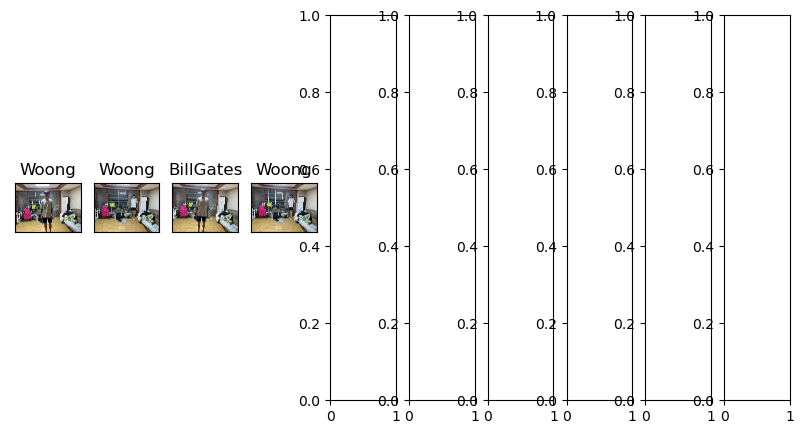

In [149]:
fig, axes = plt.subplots(1, 10, figsize=(10, 5))

for i in range(10):
    axes[i].set_title(str(pred[i]))
    axes[i].imshow(imread(test_filepaths[i]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

In [112]:
filepath='../data/images/Test/test0.jpg'
cascade = cv2.CascadeClassifier(cascade_path)
img = imread(filepath)
faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
print(faces)

()


In [113]:
fig = plt.figure()
for i, faces in enumerate(faces):
    plt.subplot(3,3,i+1)
    plt.imshow(faces)

<Figure size 640x480 with 0 Axes>

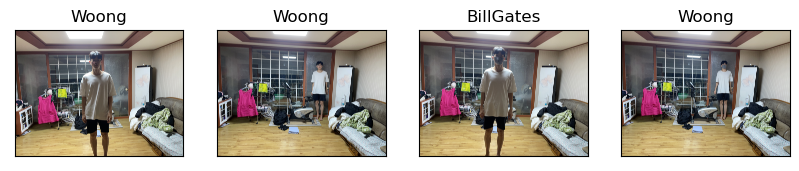

In [151]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

for i in range(4):
    axes[i].set_title(str(pred[i]))
    axes[i].imshow(imread(test_filepaths[i]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()
